# Predicting Adult Height

Predicting adult height with a simple linear model. Also playing with a bayesian linear model just so I can better see the uncertainity. (Yes all heights are in inches)

In [1]:
import numpy as np
import pymc3 as pm
import bambi as bm
import pymc3.math as pmath
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as graph
from IPython.display import display, Markdown

graph.style.use('fivethirtyeight')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/home/stephen/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/stephen/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('data/GaltonFamilies.csv', index_col=0)
df['isMale'] = (df['gender'] == 'male').astype(int)

print(df.shape)
display(df.head())

(934, 9)


,family,father,mother,midparentHeight,children,childNum,gender,childHeight,isMale
1,001,78.5,67.0,75.43,4,1,male,73.2,1
2,001,78.5,67.0,75.43,4,2,female,69.2,0
3,001,78.5,67.0,75.43,4,3,female,69.0,0
4,001,78.5,67.0,75.43,4,4,female,69.0,0
5,002,75.5,66.5,73.66,4,1,male,73.5,1


In [3]:
print(f'Number of families = {len(df.family.unique())}')

Number of families = 205


# Estimating Heritability (Quick aside)

Quickly let's estimate the heritability since we have the ability here to do that with credible intervals.

In [4]:
%%time
midparent_offspring_model = bm.Model(df[['midparentHeight', 'childHeight', 'isMale', 'family']])
h2_results = midparent_offspring_model.fit(
    'childHeight ~ midparentHeight + isMale', random='1|family', 
    samples=5000, chains=4
)

/home/stephen/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,119.9:  76%|███████▋  | 38246/50000 [00:33<00:10, 1140.51it/s]  
Convergence archived at 38400
Interrupted at 38,399 [76%]: Average Loss = 32,216
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [childHeight_sd_interval__, 1|family_offset, 1|family_sd_log__, isMale, midparentHeight, Intercept]
100%|██████████| 5500/5500 [01:09<00:00, 78.79it/s] 
The number of effective samples is smaller than 10% for some parameters.


CPU times: user 39.8 s, sys: 4.71 s, total: 44.5 s
Wall time: 2min 21s


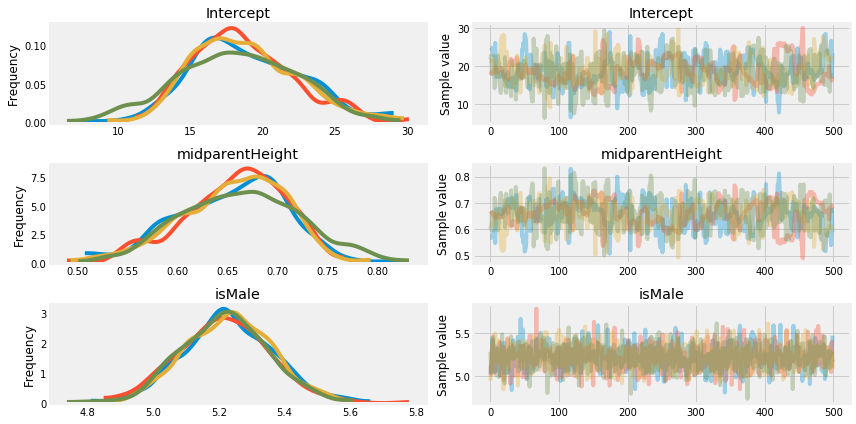

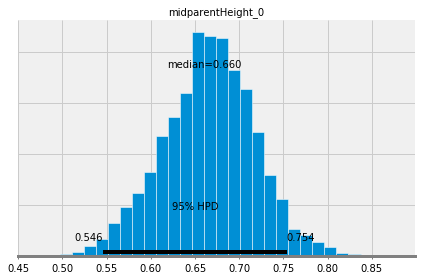

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|family_sd,0.967042,0.101324,0.776821,1.159715,1445,0.999865
Intercept,18.590702,3.733264,12.142124,26.222623,278,1.001878
childHeight_sd,1.958985,0.051052,1.851596,2.048852,2000,0.999233
isMale,5.221589,0.135132,4.951710,5.474783,1885,1.001133
midparentHeight,0.657432,0.053818,0.546877,0.749604,280,1.001886


In [5]:
pm.traceplot(
    midparent_offspring_model.backend.trace[2500::5], 
    varnames=['Intercept', 'midparentHeight', 'isMale']
)
graph.show()

pm.plot_posterior(
    midparent_offspring_model.backend.trace, 
    varnames=['midparentHeight'], 
    point_estimate='median'
)
graph.show()

display(h2_results[2500::5].summary())

Gelman Rubin values close to 1 means that the chains have converged. Therefore the coef for `midparentHeight` is the estimated heritability of height.

/home/stephen/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


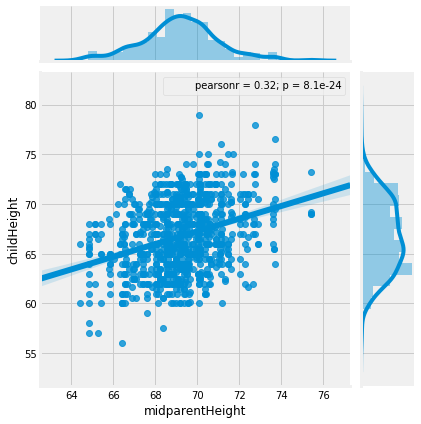

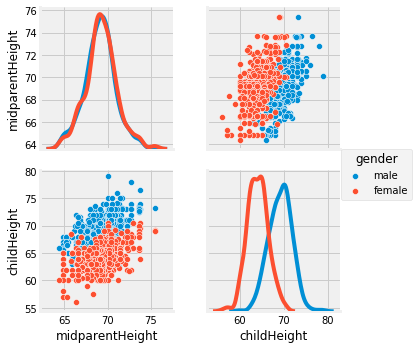

In [6]:
sns.jointplot(df['midparentHeight'], df['childHeight'], kind='reg')
graph.show()

sns.pairplot(data=df[['midparentHeight', 'childHeight', 'gender']], hue='gender', diag_kind='kde')
graph.show()

# Model the problem

In [7]:
df.columns

Index(['family', 'father', 'mother', 'midparentHeight', 'children', 'childNum',
       'gender', 'childHeight', 'isMale'],
      dtype='object')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            childHeight   No. Observations:                  934
Model:                            GLM   Df Residuals:                      930
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:               4.685886962145977
Method:                          IRLS   Log-Likelihood:                -2044.6
Date:                Sat, 09 Jun 2018   Deviance:                       4357.9
Time:                        18:24:21   Pearson chi2:                 4.36e+03
No. Iterations:                     2                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            16.5212      2.727      6.058      0.000      11.176      21.866
C(gender)[T.male]     5.2150      0.142     36.775      0.000       4.937       5.493
father                0.3928      0.029     13.699      0.000       0.337       0.449
mother                0.3176      0.031     10.245      0.000       0.257       0.378
=====================================================================================
"""

/home/stephen/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


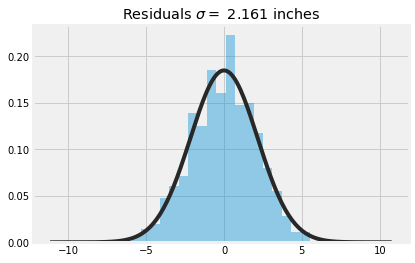

CPU times: user 286 ms, sys: 149 ms, total: 435 ms
Wall time: 224 ms


In [8]:
%%time
# Frequentist GLM
fglm = smf.glm('childHeight ~ father + mother + C(gender)', data=df).fit()

display(fglm.summary())

graph.title(f'Residuals $\sigma =$ {fglm.resid_pearson.std():0.3f} inches')
sns.distplot(fglm.resid_pearson, fit=stats.norm, kde=False)
graph.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [male, mother, mother_sd_log__, father, father_sd_log__, b, error_interval__]
100%|██████████| 5500/5500 [02:45<00:00, 33.17it/s]
The acceptance probability does not match the target. It is 0.9015458802755478, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799329955879055, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9179572698147127, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9038157553345078, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


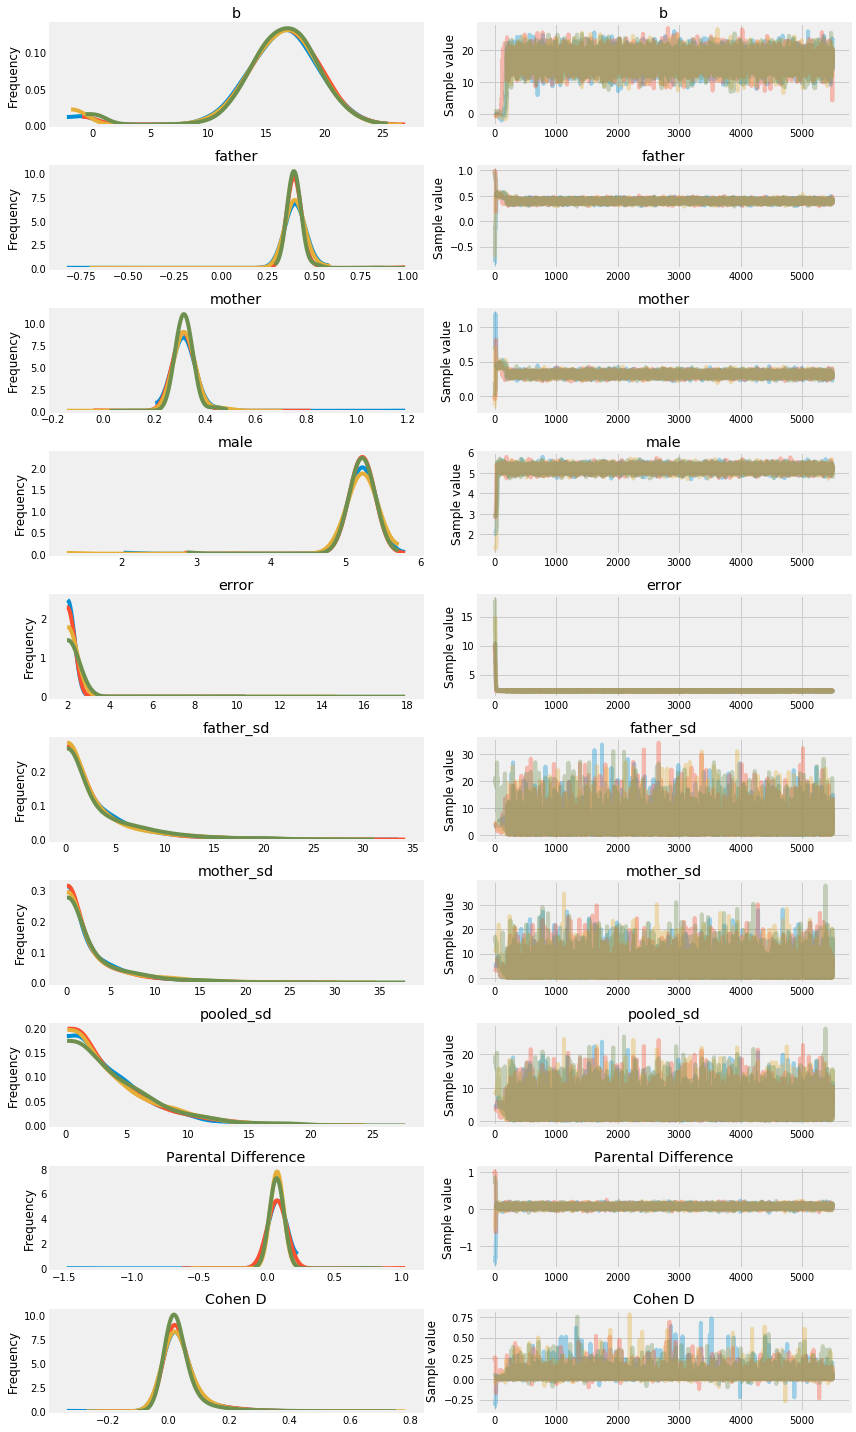

CPU times: user 6.52 s, sys: 2.52 s, total: 9.04 s
Wall time: 2min 50s


In [9]:
%%time
with pm.Model() as bayes_regression:    
    # Priors Bayesian GLM
    # childHeight ~ father + mother + C(gender)
    error = pm.Uniform('error', lower=0, upper=25)
    b = pm.Normal('b', mu=0, sd=100**2)
    
    father_sd = pm.HalfNormal('father_sd', sd=10)
    father = pm.Normal('father', mu=0, sd=father_sd)
    
    mother_sd = pm.HalfNormal('mother_sd', sd=10)
    mother = pm.Normal('mother', mu=0, sd=mother_sd)
    
    male = pm.Normal('male', mu=2, sd=100**2)
    
    # Some deterministics
    pooled_sd = pm.Deterministic(
        'pooled_sd', 
        np.sqrt((father_sd**2 + mother_sd**2) / 2)
    )
    parental_diff = pm.Deterministic('Parental Difference', father - mother)
    cohen_d = pm.Deterministic('Cohen D', parental_diff / pooled_sd)
    
    # Model Likelihood
    obs = pm.Normal(
        'y', 
        mu=(father * df['father']) + (mother * df['mother']) + (male * df['isMale']) + b, 
        sd=error,
        observed=df['childHeight']
    )
    
    # Sample
    trace = pm.sample(int(5e3), n_init=1000, njobs=4, discard_tuned_samples=False)
    
    # Posterior
    pm.traceplot(trace)
    graph.show()
    
    # trace = trace[1000::3]  # Verified with autocorrelation plots

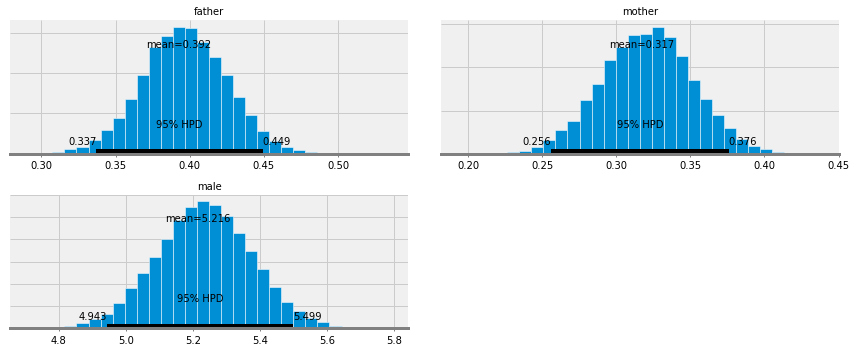

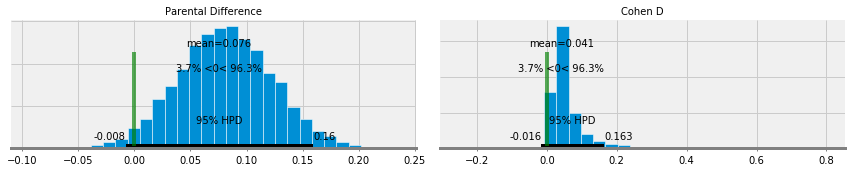

In [10]:
good_trace = trace[2000:]

pm.plot_posterior(good_trace, varnames=['father', 'mother', 'male'])
graph.show()

pm.plot_posterior(good_trace, ref_val=0, varnames=['Parental Difference', 'Cohen D'])
graph.show()


 Effect size | d |	Reference |
----|----|----|
 Very small |	0.01 |	Sawilowsky, 2009 |
 Small	| 0.20 | Cohen, 1988 |
 Medium |	0.50 |	Cohen, 1988 |
 Large |	0.80 |	Cohen, 1988 |
 Very large |	1.20 |	Sawilowsky, 2009 |
 Huge |	2.0 |	Sawilowsky, 2009 |


This parental effect is very small!

100%|██████████| 100/100 [00:01<00:00, 92.35it/s]


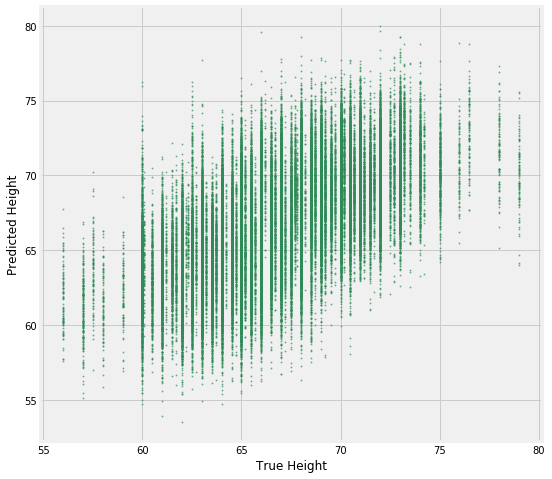

In [11]:
# Predictive Posterior Checks
graph.figure(figsize=(8, 8))
for row in zip(df['childHeight'], pm.sample_ppc(good_trace, samples=100, model=bayes_regression)['y'].T):
    graph.plot(row[0] * np.ones(row[1].shape), row[1], 'o', markersize=1, color='seagreen', alpha=0.5)
graph.xlabel('True Height')
graph.ylabel('Predicted Height')
graph.show()

# Getting Predictions From Models

In [12]:
def create_point(mom, dad, gender):
    p = pd.DataFrame(
        {'mother': mom, 'father': dad, 'gender': 'female' if 'f' in gender else 'male'},
        index=[0]
    )
    p['isMale'] = (p['gender'] == 'male').astype(int)
    return p

In [13]:
def point_estimate(mom, dad, gender):
    """Frequentist single point estimate"""
    point = create_point(mom, dad, gender)
    return fglm.predict(point)[0]

display(Markdown(f'Anthony estimated at {point_estimate(62, 67, "m"):0.2f} inches'))

Anthony estimated at 67.75 inches

In [14]:
# Posterior parameters
trace_df = pm.trace_to_dataframe(good_trace)
display(trace_df.head(3))

,b,father,mother,male,error,father_sd,mother_sd,pooled_sd,Parental Difference,Cohen D
0,19.059475,0.400499,0.269796,5.072681,2.112910,6.166203,2.306282,4.655158,0.130703,0.028077
1,19.746565,0.390708,0.271155,5.162730,2.092894,16.440683,0.792529,11.638818,0.119553,0.010272
2,19.332299,0.395404,0.272082,5.099386,2.086200,20.484913,1.432012,14.520370,0.123323,0.008493


/home/stephen/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


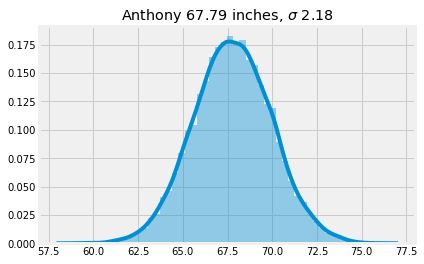

In [15]:
def bayes_estimate(mom, dad, gender):
    point = create_point(mom, dad, gender)
    est = []
    for _, row in trace_df.iterrows():
        p = ((row['father'] * point['father']) + (row['mother'] * point['mother']) + (row['male'] * point['isMale']) + row['b'])
        p += stats.norm(0, row['error']).rvs()
        est.append(p)
    return np.array(est).flatten()

# Test Values
anthony = bayes_estimate(62, 67, 'm')
graph.title(f'Anthony {anthony.mean():0.2f} inches, $\sigma$ {anthony.std():0.2f}')
sns.distplot(anthony)
graph.show()

# Great!

type in heights and gender below to play with predictions

/home/stephen/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


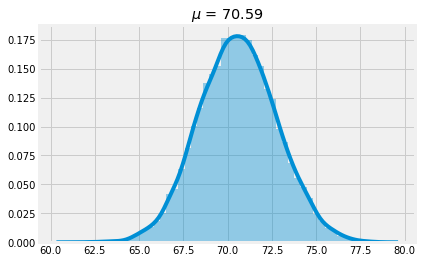

In [16]:
test_point = bayes_estimate(71, 67, 'm')
graph.title(f'$\mu$ = {test_point.mean():0.2f}')
sns.distplot(test_point)
graph.show()